# Intelligente systemer: Evaluere og forbedre modeller
Velkommen til denne notebooken som inngår i Høyskolen Kristianias emne «Utvikling og anvendelse av intelligente systemer», modul 3, «Test og evaluering».

## Hvordan du bruker denne notebooken 
Dette er en Jupyter notebook med tekst og Python-kode som du kjører ved å trykke shift-enter. Hensikten er å bli kjent med relevante konsepter i praksis, ikke nødvendigvis å forstå alle detaljer i koden. Ta deg god tid til å lese teksten, se gjennom koden, kjøre kodecellene (pass på riktig rekkefølge), studere resultatene, og tenke gjennom hva vi gjør, hvorfor og hvordan.

Underveis i teksten vil du finne referanser til Canvas-oppgaver _i kursiv_. Gå til Canvas og besvar spørsmålene der før du går videre i notebooken.

## Problemstilling: Trene en modell som predikerer løpstid i mosjonsløp
I denne notebooken skal vi se hvordan vi jobber iterativt med å trene en modell som predikerer løpstid i mosjonsløp, vurdere hvor god den er, forbedre den, og trene den på nytt flere ganger. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
import math

from sklearn.metrics import mean_squared_error,r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_validate
import datetime
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from scipy.stats import randint, uniform

np.random.seed(1)
random.seed(3)

In [2]:
# En hjelpefunksjon for å plotte en correlation heatmap
def corr_heatmap(df, figsize=(10, 10)):
    _, axs = plt.subplots(figsize=figsize)
    ax = sns.heatmap(
        df, vmin=-1, vmax=1, cmap="BrBG", linewidths=0.5, annot=True, ax=axs)
    ax.set_title('Correlation matrix')
    return ax

## Utforske dataene
Før man begynner å jobbe med et maskinlæringsproblem, må man alltid utforske dataene, se om det er noe feil i dem, og prøve å forstå dem bedre. Dette datasettet er syntetisk generert, og vi har allerede luket ut alle datapunkter som er feil. Likevel er det lurt å få en oversikt over dataene, fordi det kan hjelpe oss å utvikle en bedre modell.

In [3]:
# Vi leser inn dataene
data = pd.read_csv("data/mosjonslop_cleaned.csv")

In [6]:
data

,tid,trening,alder,klasse,løpsted
0,0:40:16,2,45,herre,Oslo
1,0:46:25,8,19,dame,Tromsø
2,0:35:21,5,48,herre,Tromsø
3,0:52:34,5,65,herre,Tromsø
4,0:45:58,5,28,dame,Bergen
...,...,...,...,...,...
7393,0:37:15,10,54,dame,Bergen
7394,0:23:58,10,23,herre,Tromsø
7395,0:26:48,4,43,herre,Oslo
7396,0:33:22,5,47,dame,Bergen


In [5]:
# Vi forenkler navnet på variabelen for å gjøre det litt enklere for oss selv
data.rename(columns={"trening per uke":"trening"}, inplace=True)

In [7]:
# Her trekker vi ut antall minutter fra tiden som vi
# får oppgitt i minutter:sekunder. Dette er et eksempel på feature
# engineering som vi må gjøre før vi kan begynne å utforske dataene.
data["tid"] = pd.to_timedelta(
    data["tid"]).apply(lambda x: x.total_seconds()/60.0)

For å få et raskt overblikk over dataene, kan vi lage histogrammer for alle de numeriske variablene og scatterplot for alle kombinasjonene av numeriske variabler. Datavisualiseringsbiblioteket Seaborn har en fin funksjon for å gjøre dette. Nedenfor ser du histogrammene langs diagonalen og scatterplot i nedre diagonal.

In [8]:
data

,tid,trening,alder,klasse,løpsted
0,40.266667,2,45,herre,Oslo
1,46.416667,8,19,dame,Tromsø
2,35.350000,5,48,herre,Tromsø
3,52.566667,5,65,herre,Tromsø
4,45.966667,5,28,dame,Bergen
...,...,...,...,...,...
7393,37.250000,10,54,dame,Bergen
7394,23.966667,10,23,herre,Tromsø
7395,26.800000,4,43,herre,Oslo
7396,33.366667,5,47,dame,Bergen


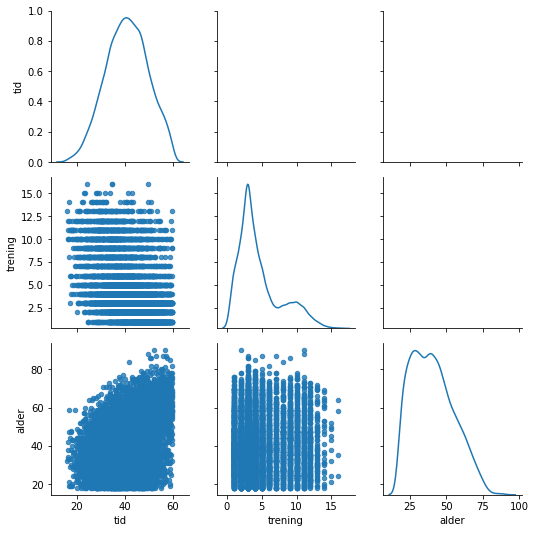

In [9]:
# Vi lager et pairgrid objekt
grid = sns.PairGrid(
    data=data, vars=["tid", "trening", "alder"], diag_sharey=False)

# Nedre hjørne ser scatterplot
grid.map_lower(plt.scatter, alpha=0.8, s=20)

# Diagonalen er et histogram
grid.map_diag(sns.kdeplot)
plt.show()

Vi kan også lage et såkalt correlation heatmap for alle de numeriske variablene, som vist nedenfor. 

<AxesSubplot:title={'center':'Correlation matrix'}>

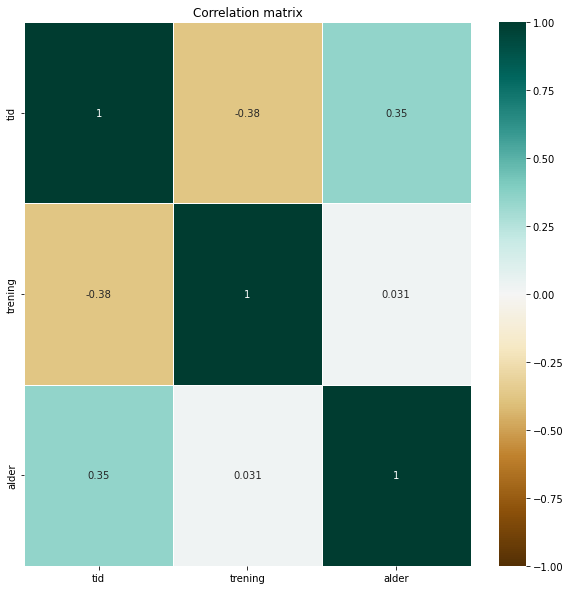

In [10]:
corr_heatmap(data.corr())

Fokuset for denne notebooken er testing og evaluering. For ikke å bruke for mye tid på datautforskning, følger her en liste over hva vi konkluderer med basert på disse plottene: 
- Alle løper på under 60 minutter, antageligvis fordi det er en makstid. Snittet er på 30 minutter.
- Deltagerne trener fra 1 til 15 timer i uken. Snittet er på rundt 3.
- Vi finner alle aldre fra 18 til 90. Ingen under 18 år. Det ser ut som om det er en nedre aldersgrense.
- Det er som forventet en negativ korrelasjon mellom trening og tid: Desto mer man trener, desto fortere løper man. Denne effekten ser ut til å være sterkest når man trener lite. Med andre ord så betyr det mye mer å gå fra 1 til 2 timers trening i uken enn å gå fra 5 til 6 timer. Altså er dette ikke en ren lineær effekt. 
- Det er som forventet en positiv korrelasjon mellom alder og tid: Eldre personer løpere saktere. Ut fra scatterplottet kan vi se at denne effekten først og fremst skyldes at eldre ikke klarer å løpe skikkelig fort. Det ser ikke ut til at noen løpere over ca. 65 år klarer å løpe på under 30 minutter. Derimot finner vi løpere som løper sakte i alle aldersklasser. Altså er heller ikke sammenhengen mellom alder og tid utelukkende lineær. 
- Det ser ikke ut til at det er noen videre sammeheng mellom antall treningstimer og alder. 

I modul 1 blir den utforskende dataanalysen gjennomgått i detalj. 

## Modellbygging

### Før vi begynner å gjøre noe med dataene
Før vi begynner å gjøre noe som helst med dataene, bør vi definere en baselinemodell. Vi bør også hente ut testdataene, som vi ikke skal se på før alle valg angående modellen er tatt.

#### Definere en baselinemodell
Før man begynner å jobbe med å utvikle en modell, bør man alltid tenke på en baselinemodell. Baselinemodellen skal helst være den beste eksisterende modellen for problemstillingen. Den er hva vi måler eventuell forbedring relativt til. Noen ganger har vi en slik modell i forveien, og noen ganger må vi lage den selv ved hjelp av enkle antakelser. For eksempel er det et minimumsmål at en klassifiserings-algoritme må være bedre enn om man gjetter klassen tilfeldig (korrigert for eventuell ubalanse i data).

I dette tilfellet velger vi en veldig enkel baselinemodell som alltid predikerer gjennomsnittstiden. Vi predikerer altså at alle løperene løper på gjennomsnittet av alle tidligere løpstider. En tilpasset modell bør være mer presis enn dette.

Man kan gjerne lage en bedre baselinemodell. Kan du tenke på noen? 

_Oppgave: Svar på flervalgsspørsmål 1 (vist nedenfor) i Canvas, og reflekter litt rundt svarene._

1. _Hva kan fungere som en god baselinemodell når du skal trene en modell som predikerer løpstiden på et 5 kilometers mosjonsløp?_

#### Splitte i trenings-, validerings- og testdata 
Før vi begynner å trene en modell, er det viktig å splitte dataene i trenings-, validerings- og testdata. Først henter vi ut testdataene, som vi ikke skal se på før alle valg om modellen er tatt: hvilken modell, hva slags preprosessering, hvilke features osv. Så dropper vi testdatene fra datasettet og står igjen med datasettet `t_v_data` som vi kan bruke til trening (t) og validering (v). Deretter splitter vi disse dataene i henholdsvis trenings- og valideringsdata.

In [11]:
# Disse dataene skal vi ikke se på før helt til slutt
test_data = data.sample(frac=0.2, random_state=1)
# Trenings- og valideringsdata
t_v_data = data.drop(test_data.index).reset_index(drop=True)
X_train, X_eval, y_train, y_eval = train_test_split(
    t_v_data.drop(columns="tid"), t_v_data["tid"], test_size=0.20, random_state=1)
# Vi resetter indeksene fordi splittet var tilfeldig,
# og det er ryddigere å se på dataframes med fortløpende indeks
X_train.reset_index(inplace=True, drop=True)
X_eval.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_eval.reset_index(inplace=True, drop=True)

In [12]:
# Treningsdata før transformering
X_train.head()

,trening,alder,klasse,løpsted
0,13,32,herre,Grimstad
1,2,31,dame,Oslo
2,3,39,dame,Kristiansand
3,5,25,dame,Kristiansand
4,3,30,dame,Tromsø


In [18]:
y_train.head()

0    16.133333
1    54.066667
2    44.166667
3    38.333333
4    48.700000
Name: tid, dtype: float64

### Preprosessering av dataene

#### Gjøre om alt til tall
En maskinlæringsalgoritme kan kun lese tall. Derfor starter vi med å gjøre om alle kategoriske variabler til tall. Siden de kategoriske variablene våre (klasse og løpssted) ikke har noen naturlig rangering, velger vi å gjøre en-hot-koding (one-hot encoding).

*En liten kommentar angående koden for en-hot-koding: Det er mulig å gjøre en-hot-koding på hele datasettet med funksjonen `get_dummies()`. Nedenfor har vi vist hvordan vi kan gjøre en-hot-koding ved først å finne kodingen for ett datasett, i dette tilfelle `X_train`. Så bruker vi denne kodingen på `X_eval` og testdataene etterpå. Denne måten å gjøre det på, fungerer også dersom dataene som skal transformeres ikke er tilgjengelige med en gang. Med andre ord: Du kan finne kodingen på ett datasett og så andvende den på et annet etterpå, for eksempel på data som kommer inn når modellen er satt i produksjon.*

In [22]:
# One-hot encoding av løpssted 
# (dersom du vil kjøre denne cellen på nytt, må du kjøre fra toppen av modellbygging)
enc_lopsted = OneHotEncoder(drop="first")
enc_lopsted.fit(X_train[["løpsted"]])
X_train = X_train.reset_index(drop=True).drop(
    columns=["løpsted"]).join(pd.DataFrame(enc_lopsted.transform(
        X_train[["løpsted"]]).toarray(), columns=enc_lopsted.categories_[0][1:]))
X_eval = X_eval.reset_index(drop=True).drop(
    columns=["løpsted"]).join(pd.DataFrame(enc_lopsted.transform(
        X_eval[["løpsted"]]).toarray(), columns=enc_lopsted.categories_[0][1:]))

In [29]:
X_train

,trening,alder,klasse,Grimstad,Kristiansand,Oslo,Tromsø
0,13,32,herre,1.0,0.0,0.0,0.0
1,2,31,dame,0.0,0.0,1.0,0.0
2,3,39,dame,0.0,1.0,0.0,0.0
3,5,25,dame,0.0,1.0,0.0,0.0
4,3,30,dame,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...
4729,1,60,dame,0.0,0.0,0.0,0.0
4730,3,19,herre,0.0,0.0,0.0,1.0
4731,2,19,herre,0.0,0.0,0.0,0.0
4732,4,29,dame,0.0,0.0,0.0,0.0


In [30]:
# One-hot encoding av klasse 
# (dersom du vil kjøre denne cellen på nytt, må du kjøre fra toppen av modellbygging)
enc_klasse = OneHotEncoder(drop="first")
enc_klasse.fit(X_train[["klasse"]])
X_train = X_train.reset_index(drop=True).drop(
    columns=["klasse"]).join(pd.DataFrame(enc_klasse.transform(
        X_train[["klasse"]]).toarray(),columns=enc_klasse.categories_[0][1:]))
X_eval = X_eval.reset_index(drop=True).drop(
    columns=["klasse"]).join(pd.DataFrame(enc_klasse.transform(
        X_eval[["klasse"]]).toarray(),columns=enc_klasse.categories_[0][1:]))

In [31]:
#Slik ser dataene ut etter one-hot encoding
X_train

,trening,alder,Grimstad,Kristiansand,Oslo,Tromsø,herre
0,13,32,1.0,0.0,0.0,0.0,1.0
1,2,31,0.0,0.0,1.0,0.0,0.0
2,3,39,0.0,1.0,0.0,0.0,0.0
3,5,25,0.0,1.0,0.0,0.0,0.0
4,3,30,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...
4729,1,60,0.0,0.0,0.0,0.0,0.0
4730,3,19,0.0,0.0,0.0,1.0,1.0
4731,2,19,0.0,0.0,0.0,0.0,1.0
4732,4,29,0.0,0.0,0.0,0.0,0.0


#### Skalere dataene
Dersom dataene har veldig forskjellige verdier, bør man alltid skalere dem slik at verdiene er mer sammenlignbare. Om man ikke gjør det, vil mange modeller som baserer seg på distanser tro at en variabel er mye viktigere bare fordi verdiene er større.  I tillegg er mange modeller optimert for å trene raskere på skalerte data.

In [32]:
scalerX = MinMaxScaler()
# Merk her at vi skalerer med X_train og bruker den senere til å transformere evaluering
scalerX.fit(X_train)
X_train = scalerX.transform(X_train)
X_eval = scalerX.transform(X_eval)

In [33]:
X_train

array([[0.8       , 0.19444444, 1.        , ..., 0.        , 0.        ,
        1.        ],
       [0.06666667, 0.18055556, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.13333333, 0.29166667, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.06666667, 0.01388889, 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.2       , 0.15277778, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.06666667, 0.36111111, 0.        , ..., 0.        , 1.        ,
        0.        ]])

## Trene modellen

### Baselinemodell 
Etter at vi har gjort preprosesseringen, kan vi begynne å trene modellen. Men aller først vil vi sjekke resultatet fra baselinemodellen. Vi velger å regne ut både RMSE og R2. Tenk gjennom hva RMSE og R2 representerer. Hva sier de to evalueringsmetrikkene om modellen?

In [42]:
y_eval

0       40.416667
1       37.366667
2       52.733333
3       51.616667
4       43.600000
          ...    
1179    43.583333
1180    30.216667
1181    34.900000
1182    27.316667
1183    39.466667
Name: tid, Length: 1184, dtype: float64

In [34]:
print("RMSE", np.sqrt(mean_squared_error([y_train.mean()]*len(X_eval), y_eval)))
print("R2", r2_score([y_train.mean()]*len(X_eval), y_eval))

RMSE 8.96393259084812
R2 -1.591537061569278e+30


_Oppgave: Svar på flervalgsspørsmål 2 (vist nedenfor) i Canvas._

2. _Hva stemmer angående RMSE og R2?_


### Trene og evaluere en enkel lineær modell
Vi starter med å teste en enkel lineær modell.

In [43]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [44]:
print("RMSE validering", np.sqrt(mean_squared_error(y_eval, model.predict(X_eval))))
print("RMSE trening", np.sqrt(mean_squared_error(y_train, model.predict(X_train))))

print("R2 validering", r2_score(y_eval, model.predict(X_eval)))
print("R2 trening", r2_score(y_train, model.predict(X_train)))

RMSE validering 6.249411315233585
RMSE trening 6.057592749729375
R2 validering 0.5139024271104288
R2 trening 0.51136458007908


_Oppgave: Svar på flervalgsspørsmål 3 (vist nedenfor) i Canvas._

3. _Tren en enkel lineær modell. Finn verdien til RMSE på både treningsdata og valideringsdata. Hva ser du?_


### Kryssvalidering

Dersom vi ikke har veldig mye data, har vi ikke lyst til å kaste bort 40 % av dataene våre til testdata. Da er kryssvalidering en god løsning. Selv om vi da kan utnytte trenings- og valideringsdataene til å trene modellen, kan vi ikke bruke testdataene: De skal vi ikke hente frem ennå. Vi starter med å gjøre preprosessering på dataene som ikke inneholder testdataene. 

In [45]:
t_v_data = data.drop(test_data.index).reset_index(drop=True)
enc_lopsted = OneHotEncoder(drop="first")
enc_lopsted.fit(t_v_data[["løpsted"]])
t_v_data = t_v_data.reset_index(
    drop=True).drop(columns=["løpsted"]).join(
        pd.DataFrame(enc_lopsted.transform(
            t_v_data[["løpsted"]]).toarray(), columns=enc_lopsted.categories_[0][1:]))

In [46]:
enc_klasse = OneHotEncoder(drop="first")
enc_klasse.fit(t_v_data[["klasse"]])
t_v_data = t_v_data.reset_index(drop=True).drop(
    columns=["klasse"]).join(pd.DataFrame(enc_klasse.transform(
        t_v_data[["klasse"]]).toarray(), columns=["klasse"]))

In [47]:
X_t_v = t_v_data.drop(columns="tid")
scalerX.fit(X_t_v)
X_t_v = scalerX.transform(X_t_v)
y_t_v = t_v_data[["tid"]]

#### Kryssvalidering på lineær modell

In [48]:
antall_folds = 5
cv_results = cross_validate(
    model, X_t_v, y_t_v, cv=antall_folds, scoring=(
        'r2', 'neg_mean_squared_error'), return_train_score=True)

In [49]:
# Her ser vi resultatet på forskjellige folds. Dersom de varierer for mye,
# så er det et tegn på at vi har for mange folds.
# Funksjonen for cross validation gir oss den negative versionen av MSE
# (mean squared error), derfor må vi gjøre den positiv og ta kvadratroten for å kunne sammenligne
np.sqrt(cv_results["test_neg_mean_squared_error"]*-1)

array([5.86649124, 6.28060401, 6.13127137, 6.13893674, 6.09725226])

In [50]:
# Vi finner gjennomsnitet av alle folds for å få en et mål på RMSE
sum(np.sqrt(cv_results["test_neg_mean_squared_error"]*-1))/antall_folds

6.102911124908814

#### Random forest med standardparametere

In [53]:
forestmodel = RandomForestRegressor(random_state=1)
# Merk at vi må gjøre om y_t_v som er en pandas-liste til en 1 d array
cv_results = cross_validate(forestmodel, X_t_v,y_t_v.values[:, 0], cv=antall_folds, scoring=(
    'r2', 'neg_mean_squared_error'), return_train_score=True)
np.sqrt(cv_results["test_neg_mean_squared_error"]*-1)

array([6.27811378, 6.43260308, 6.44601529, 6.62556094, 6.4921159 ])

In [54]:
sum(np.sqrt(cv_results["test_neg_mean_squared_error"]*-1))/antall_folds

6.454881797701179

## Hyperparametertuning
Foreløpig har vi bare testet en random-forest-modell med standard parametere. Som vi så, endte vi opp med en modell som var litt dårligere enn en enkel lineær modell. Vi bør derfor prøve å tune hyperparameterene slik at vi finner de optimale hyperparameterene. For en random-forest-modell er det en god idé å tune følgende hyperparametere: 
- `max_features` (maksimalt antall features som modellen ser på når den lager et splitt)
- `max_depth`    (maksimal dybde på trærne i random-forest-skogen)
- `n_estimators` (antall trær i random-forest-skogen; det er stort sett alltid lønnsomt å ha flere, men da blir utregningstiden lang)

Vi prøver å gjøre både tabellsøk (grid search) og tilfeldig søk (random search). Når du har funnet de optimale parameterene både ved tabellsøk og tilfeldig søk, kan du prøve å trene en modell som bruker de optimale parameterene.  

### Tabellsøk (grid search)
For `max_features` har vi valgt å sjekke opp til 4 siden det ikke er mulig å gå høyere: Vi har kun 4 features. For de to andre variablene har vi satt verdiene så høyt vi kan uten at beregningstiden blir veldig lang. Likevel kan det ta opptil flere minutter å kjøre cellen nedenfor.

In [55]:
param_range = {"max_features": range(1, 4),
               "max_depth": range(1, 15), "n_estimators": range(1, 200, 20)}
# Definer søket
grid_search = GridSearchCV(
    forestmodel, param_grid=param_range, scoring="neg_mean_squared_error", cv=3)
grid_search.fit(X_t_v,y_t_v.values[:, 0])
grid_search.best_params_

{'max_depth': 7, 'max_features': 3, 'n_estimators': 101}

Grid search returnerer bare settet med de beste hyperparameterene og ikke selve modellen. Altså er vi nødt til å trene modellen en gang til. Sett inn de optimale parameterverdiene (ifølge tabellsøket) før du kjører cellen nedenfor.

In [56]:
# Nå kan du trene en modell med de optimale hyperparameterene. 
# Sett inn verdiene dine etter likhetstegnene.
forestmodel = RandomForestRegressor(max_depth = 7 , max_features = 3 , n_estimators = 101  , random_state = 1)
cv_results = cross_validate(
    forestmodel, X_t_v, y_t_v.values[:, 0], cv=antall_folds, scoring=(
        'r2', 'neg_mean_squared_error'), return_train_score=True)
sum(np.sqrt(cv_results["test_neg_mean_squared_error"]*-1))/antall_folds

5.768459537744407

_Oppgave: Svar på flervalgsspørsmål 4 (vist nedenfor) i Canvas._

4. _Gjør hyperparametertuning på random forest-modellen. Bruk både tabellsøk (grid search) og tilfeldig søk (random search). Hva ser du?_

### Tilfeldig søk (random search)
Vi søker i samme intervaller, men gjør random search med uniform distribusjon.

In [57]:
# Definer søket
param_dist = {"max_features": randint(1, 4),
              "max_depth": randint(1, 15),
              "n_estimators": randint(1, 200)}
random_search = RandomizedSearchCV(forestmodel, param_distributions=param_dist,                   
                                   scoring="neg_mean_squared_error", cv=antall_folds, n_iter=50, random_state=1)
random_search.fit(X_t_v, y_t_v.values[:, 0])
random_search.best_params_

{'max_depth': 7, 'max_features': 3, 'n_estimators': 195}

In [58]:
# Nå kan du trene en modell med de optimale hyperparameterene.
# Sett inn verdiene dine etter likhetstegnene.
forestmodel = RandomForestRegressor(max_depth = 7 , max_features = 3 , n_estimators = 195  , random_state = 1)
cv_results = cross_validate(
    forestmodel, X_t_v, y_t_v.values[:, 0], cv=antall_folds, scoring=(
        'r2', 'neg_mean_squared_error'), return_train_score=True)
sum(np.sqrt(cv_results["test_neg_mean_squared_error"]*-1))/antall_folds

5.766509482808627

## Prøve å legge til flere variabler
Her skal du eksperimentere med hvilke variabler som er viktige og hvilke som ikke er viktige. 

In [84]:
# Her er noen nye features vi kan legge til
t_v_data["trening2"] = t_v_data["trening"]*t_v_data["trening"]
t_v_data["alder2"] = t_v_data["alder"]*t_v_data["alder"]

# Nedenfor kan du teste tre sett av forskjellige features.
# Fjern kommentartegnet for den kombinasjonen du vil teste, og kommenter vekk de andre.

#Bruk alle opprinnelige features
#use_data = t_v_data[["tid", "Grimstad", "Kristiansand","Oslo", "Tromsø", "trening", "klasse", "alder"]]

# Bruk denne for å ta vekk løpssted
#use_data = t_v_data[["tid", "trening", "klasse", "alder"]]

# Bruk denne for å ta inn annenordensledd
use_data = t_v_data[["tid","trening", "klasse", "alder","trening2", "alder2"]]
                    

In [85]:
# Merk at vi må gjøre skalering på nytt siden vi har fått inn nye variabler som også må skaleres.
# Det er denne skaleringen du også skal bruke på testdataene når du skal teste den endelige modellen.
X_t_v = use_data.drop(columns="tid")
scalerX.fit(X_t_v)
X_t_v = scalerX.transform(X_t_v)
y_t_v = use_data[["tid"]]

### Lineær modell

In [86]:
linearmodel = LinearRegression()
cv_results = cross_validate(
    linearmodel, X_t_v, y_t_v, cv=antall_folds, scoring=(
        'r2', 'neg_mean_squared_error'), return_train_score=True)
sum(np.sqrt(cv_results["test_neg_mean_squared_error"]*-1))/antall_folds

5.727646291357585

### Random forest-modell

In [87]:
# Her har vi satt inn de optimale hyperparameterene som vi fant ved random search
forestmodel = RandomForestRegressor(max_depth = 7, max_features= 3, n_estimators = 195, random_state=1)

cv_results = cross_validate(
    forestmodel, X_t_v, y_t_v.values[:, 0], cv=antall_folds, scoring=(
        'r2', 'neg_mean_squared_error'), return_train_score=True)

In [88]:
sum(np.sqrt(cv_results["test_neg_mean_squared_error"]*-1))/antall_folds
#np.sqrt(cv_results["test_neg_mean_squared_error"]*-1)

5.77048423471988

_Oppgave: Svar på flervalgsspørsmålene 5–7 (vist nedenfor) i Canvas._

5. _Tenk deg at du også har informasjon om hvilken plassering hver løper fikk i løpet, hvor støl løperen subjektivt følte seg dagen etter løpet, hva som er løperens sivilstatus, og om løperen drev med idrett som barn. Hvilke variabler kunne du brukt for å trene en modell som skulle predikere løpstiden i mosjonsløpet? Husk å tenke gjennom hvordan modellen skal brukes._
6. _Prøv deg frem med forskjellige kombinasjoner av input features når du trener en lineær modell. Start med alle de originale, prøv så å ta vekk løpsted, og prøv til slutt å legge til annenordensleddene alder2 og trening2. Hvis du regner med at en endring i RMSE på under 0,1 ikke er signifikant, hvilke variabler bør du ha med i modellen?_
7. _Gjør akkurat det samme som i forrige oppgave, men tren en RandomForestRegressor-modell i stedet. Hva observerer du?_

## Trene den optimale modellen

In [89]:
# Når du nå er ferdig, kan du trene den optimale modellen med optimale parametere og optimale utvalg av features.
# Forhåpentligvis fant du ut at det ikke var stor forskjell på random forest med og uten annenordensleddene, og 
# i tillegg var en lineær modell med annenordensleddene også like god. Som den endelige modellen velger vi en 
# random forest uten annenordensleddene. Merk at du nå bruker både trenings- og valideringsdataene til
# å trene modellen.
use_data = t_v_data[["tid", "trening", "klasse", "alder"]]
X_t_v = use_data.drop(columns="tid")
scalerX.fit(X_t_v)
X_t_v = scalerX.transform(X_t_v)
y_t_v = use_data[["tid"]]
forestmodel.fit(X_t_v, y_t_v.values[:, 0])

RandomForestRegressor(max_depth=7, max_features=3, n_estimators=195,
                      random_state=1)

## Hente frem testdataene
Nå har vi testet veldig mange muligheter, og vi har kommet frem til den beste modellen. Når du har trent den beste modellen med optimale features, er det på tide å se hvor godt den modellen fungerer på testdataene. Merk at du gjør akkurat samme preprosessering på testdataene som på treningsdataene, og at testdataene må inneholde samme features.

In [90]:
# Vi gjør samme preprosessing på testdataene som vi gjorde på trenings- og evalueringsdataene.
# Så må vi ta med de features som viste seg å være optimale for gitt modell. 
# Merk at rekkefølgen av features må være den samme som for t_v_data. Her må du selv legge til features.
test_data_t = t_v_data[["tid", "trening", "klasse", "alder"]]

In [91]:
X_test_t = test_data_t.drop(columns="tid")
y_test_t = test_data_t[["tid"]]

In [92]:
X_test_t = scalerX.transform(X_test_t)

In [93]:
# Merk at du her må legge til hvilken modell du ønsker å bruke
print("RMSE validering", np.sqrt(mean_squared_error(y_test_t, forestmodel.predict(X_test_t))))
print("R2 validering", r2_score(y_test_t,forestmodel.predict(X_test_t)))


RMSE validering 5.497517637558335
R2 validering 0.6031007715260461


_Oppgave: Svar på flervalgsspørsmål 8 (vist nedenfor) i Canvas._

8. _Forhåpentligvis fant du at en random forest-modell med eller uten annenordensleddene og en lineær modell med annenordensleddene ga omtrent like gode resultater. Hvis vi velger en random forest-modell uten annenordensleddene som den beste modellen og tester den på testdataene, hva observerer du?_

## Ekstrapolering
I denne oppgaven skal vi se på hva som skjer når vi prøver å bruke en modell på data den ikke er trent på. Først skal du trene både en lineær regresjonsmodell og en random forest regresjonsmodell. For å gjøre det enkelt bruker vi bare variablene klasse, alder og trening. Dette er gjort for deg. Bruk så disse modellene til å predikere hvor fort et barn mellom 0 og 18 år vil løpe 5 km. Hva observerer du? 

In [94]:
simple_data = t_v_data[["tid", "klasse", "alder", "trening"]]

In [95]:
# Skalerer dataene
X_simple = simple_data.drop(columns="tid")
scalerX.fit(X_simple)
X_simple = scalerX.transform(X_simple)
y_simple = simple_data[["tid"]]

In [96]:
# Trener en lineær modell og en random forest modell
linearmodel = LinearRegression()
linearmodel.fit(X_simple, y_simple)
forestmodel = RandomForestRegressor(
    max_depth=7, max_features=3, n_estimators=140, random_state=1)
forestmodel.fit(X_simple, y_simple.values[:, 0])

RandomForestRegressor(max_depth=7, max_features=3, n_estimators=140,
                      random_state=1)

In [97]:
# Her ser du hvordan du kan estimere løpstiden til en som er 18 år gammel,
# trener 3 timer i uken og er mann, med en lineær regresjonsmodell
alder = 18
trening = 3
klasse = 1
runner = [[klasse, alder, trening]]
runner = scalerX.transform(runner)
linearmodel.predict(runner)

C:\Users\hansc\anaconda3\envs\kristiania\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


array([[33.30586315]])

In [98]:
# Og her gjør du samme prediksjon med en random forest regresjonsmodell
forestmodel.predict(runner)

array([35.92837348])

_Oppgave: Svar på flervalgsspørsmålene 9 og 10 (vist nedenfor) i Canvas._

9. _Nå skal vi se på hva som skjer når vi prøver å bruke modellen på data den ikke er trent på. Du skal trene både en random forest-modell og en lineær modell. For enkelthets skyld tar vi bare med variablene klasse, alder og trening her. Bruk de to modellene til å predikere hvor fort et barn mellom 0 og 18 år vil løpe, og prøv ut litt forskjellige aldere. Hva observerer du?_
10. _Tenk deg at du har trent en modell og merker at den er overtilpasset, det vil si at den presterer mye bedre på treningsdataene enn på valideringsdataene. Hva kan du gjøre med det?_